In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
import time
import csv
import os
from nltk.tokenize import word_tokenize
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle

In [2]:
train_data_path = '/kaggle/input/sarcasm-detection/SarcasmHeadlinesDataset_training.csv'
training_data_df = pd.read_csv(train_data_path)
training_data_df.columns

Index(['ARTICLE_LINK', 'TEXT ', 'IS_SARCASTIC', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [3]:
training_data_df = training_data_df[['TEXT ', 'IS_SARCASTIC']]
training_data_df['IS_SARCASTIC'] = pd.to_numeric(training_data_df['IS_SARCASTIC'], errors='coerce')
train_data_df_cleaned = training_data_df[training_data_df['IS_SARCASTIC'].isin([0, 1])]
invalid_rows_after_cleanup = train_data_df_cleaned[~train_data_df_cleaned['IS_SARCASTIC'].isin([0, 1])]
invalid_rows_count_after_cleanup = len(invalid_rows_after_cleanup)
training_data_df = train_data_df_cleaned
training_data_df.rename(columns={"TEXT ": "TEXT"}, inplace=True)
# training_data_df.columns
# training_data_df.iloc[6932]
training_data_df.head()

,TEXT,IS_SARCASTIC
0,it's another ho-ho-horowitz christmas!,0.0
1,quiz: where should you live abroad?,0.0
2,praise the lord or praise the person?,0.0
3,microwave-resistant potato alarms scientists,1.0
4,rude guy unfortunately says something funny,1.0


In [4]:
train_val_split_factor = 0.8
num_training_samples = int(len(training_data_df) * train_val_split_factor)
shuffled_indices = np.random.RandomState(seed=150).permutation(len(training_data_df))
train_indices = shuffled_indices[:num_training_samples]
val_indices = shuffled_indices[num_training_samples:]
train_data_df = training_data_df.iloc[train_indices].reset_index(drop=True)
val_df = training_data_df.iloc[val_indices].reset_index(drop=True)

In [5]:
len(train_data_df), len(val_df)

(20545, 5137)

In [6]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['TEXT']
        # Ensure targets are floats
        self.targets = df['IS_SARCASTIC'].astype(float).values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        target = self.targets[index]

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            # Ensure the target is a tensor of type float
            'targets': torch.tensor(target, dtype=torch.float)
        }

# Example usage
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 128


# print(train_dataset[0])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
train_dataset = CustomDataset(train_data_df, tokenizer, max_length)
validation_dataset = CustomDataset(val_df, tokenizer, max_length)
batch_size = 8


train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)

validation_data_loader = torch.utils.data.DataLoader(validation_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [8]:
class BERTClass(nn.Module):
    def __init__(self, hidden_dim=100):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(768, hidden_dim) 
        self.linear2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(input_ids, attention_mask=attn_mask, token_type_ids=token_type_ids)
        output_dropout = self.dropout(output.pooler_output)
        output = F.relu(self.linear(output_dropout))
        output = self.linear2(output)
#         output = self.sigmoid(output)
        return output

hidden_dim = 100
# model = BERTClass(hidden_dim)
model = BERTClass()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [9]:
model.to(device)
model = nn.DataParallel(model)
# loss_fn = nn.CrossEntropyLoss()
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=0.00001)

In [10]:
def train_model(model, optimizer, train_dataloader):
    model.train() 
    train_loss = 0
    correct_predictions = 0
    total_predictions = 0
    train_time = time.time()

    for batch_idx, data in enumerate(train_dataloader):
        ids = data['input_ids'].to(device, dtype=torch.long)
        mask = data['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)  # Ensure targets are float if using BCELoss

        outputs = model(ids, mask, token_type_ids)
        optimizer.zero_grad()

        loss = loss_fn(outputs, targets.unsqueeze(1))

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        output_probabilities = torch.sigmoid(outputs) 
        preds = (output_probabilities >= 0.5).float() 
        correct_predictions += torch.sum(preds.squeeze(1) == targets).item()
#         print(preds.shape)
#         print(targets.shape)
#         correct_predictions += torch.sum(torch.eq(preds, targets)).item()

        total_predictions += targets.size(0)

        elapsed_time = (time.time() - train_time) / 60
#         if batch_idx % 50 == 0:
#             print(f"Batch {batch_idx + 1}, Loss: {loss.item():.4f}, Time Elapsed: {elapsed_time:.4f} min")
            
#         if batch_idx == 5:
#             break

    avg_train_loss = train_loss / len(train_dataloader)
    accuracy = correct_predictions / total_predictions
    elapsed_time = (time.time() - train_time) / 60
#     print(f"Train correct predictions: {correct_predictions} out of {total_predictions}")

#     print(f"Training completed: Average Loss: {avg_train_loss:.4f}, Accuracy: {accuracy:.4f}, Total Time: {elapsed_time:.2f} min")

    return avg_train_loss, accuracy


In [11]:
def validate_model(model, val_dataloader):
    model.eval()  
    val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    val_time = time.time()

    with torch.no_grad():
        for batch_idx, data in enumerate(val_dataloader):
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)

            outputs = model(ids, mask, token_type_ids)
#             loss = loss_fn(outputs, targets)
            loss = loss_fn(outputs, targets.float().unsqueeze(1))

            val_loss += loss.item()

#             softmax_outputs = F.softmax(outputs, dim=1)
#             preds = torch.argmax(softmax_outputs, dim=1)
            
            
            output_probabilities = F.sigmoid(outputs)
            preds = (output_probabilities >= 0.5).float()


            correct_predictions += torch.sum(preds.squeeze(1)  == targets).item()
            total_predictions += targets.size(0)
#             if batch_idx == 5:
#                 break

    avg_val_loss = val_loss / len(val_dataloader)
    accuracy = correct_predictions / total_predictions

    elapsed_time = (time.time() - val_time) / 60
#     print(f"Validation correct predictions: {correct_predictions} out of {total_predictions}")
#     print(f"Average validation loss: {avg_val_loss:.4f}")
#     print(f"Validation accuracy: {accuracy:.4f}")
#     print(f"Validation time: {elapsed_time:.2f} minutes")

    return avg_val_loss, accuracy


In [12]:
model_save_path = 'model.pth' 
model_state_dict_path = 'model_state_dict.pth'
epochs = 4
training_losses = []
training_accs = []
val_losses = []
val_accs = []
start_time = time.time()
for epoch in range(epochs):
    loss, accuracy = train_model(model,optimizer,train_data_loader)
    training_losses.append(loss)
    training_accs.append(accuracy)
    val_loss, val_acc = validate_model(model, validation_data_loader)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    e_time = (time.time() - start_time)/60
    print(f"epoch: {epoch+1}, train loss: {loss:.4f}, val. loss: {val_loss:.4f}, train acc: {accuracy:.4f}, val acc: {val_acc:.4f}, time: {e_time:.2f} mins")
    torch.save(model, model_save_path)
    torch.save(model.state_dict(), model_state_dict_path)
    epoch_nums = list(range(1, epoch+2))
    csv_file_path = "losses.csv"
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Validation Loss", "Training Accuracy", "Validation Accuracy"])   
        for epoch, train_loss, validation_loss, tacc, vacc in zip(epoch_nums, training_losses, val_losses, training_accs, val_accs):
            writer.writerow([epoch, train_loss, validation_loss, tacc, vacc])

epoch: 1, train loss: 0.2769, val. loss: 0.1832, train acc: 0.8855, val acc: 0.9289, time: 9.35 mins
epoch: 2, train loss: 0.1206, val. loss: 0.1790, train acc: 0.9558, val acc: 0.9393, time: 18.69 mins
epoch: 3, train loss: 0.0551, val. loss: 0.2437, train acc: 0.9825, val acc: 0.9276, time: 28.05 mins
epoch: 4, train loss: 0.0299, val. loss: 0.2503, train acc: 0.9919, val acc: 0.9381, time: 37.40 mins


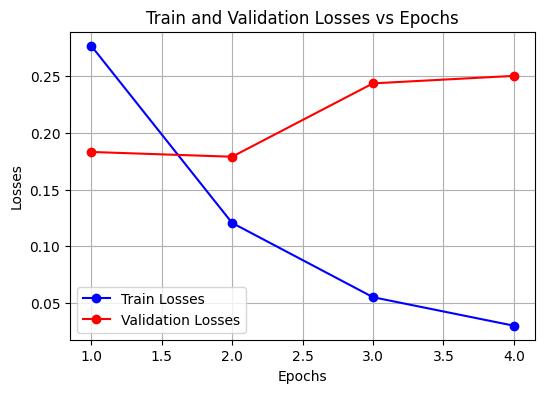

In [13]:
epoch_nums = list(range(1, epochs+1))
plt.figure(figsize=(6, 4))
plt.plot(epoch_nums, training_losses, '-o', color='b', label='Train Losses')
plt.plot(epoch_nums, val_losses, '-o', color='r', label='Validation Losses')

plt.title('Train and Validation Losses vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.grid(True)
plt.legend()
plt.savefig('train_and_validation_losses.png')
plt.show()

In [14]:
# val_loss, val_acc = validate_model(model, validation_data_loader)

In [15]:
test_data_df = pd.read_csv('/kaggle/input/sarcasm-test-new/test_data.csv')
# test_data_df
# test_data_df.columns
test_data_df = test_data_df[['ID','text']]
max_len = 100

In [16]:
def inference(model, datapoint):
    model.eval()
    with torch.no_grad():
        encodings = tokenizer.encode_plus(
            datapoint,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        ids = encodings['input_ids'].to(device, dtype=torch.long)
        mask = encodings['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
        outputs = model(ids, mask, token_type_ids)
        output_probabilities = F.sigmoid(outputs)
        preds = (output_probabilities >= 0.5).float()
    return preds

all_preds = []
for index, row in test_data_df.iterrows():
    ID = row['ID']
    sentence = row['text']
    pred_tensor = inference(model, sentence) 
    pred = int(pred_tensor.cpu().numpy().flatten()[0])
    all_preds.append((ID, pred))

results_df = pd.DataFrame(all_preds, columns=['ID', 'IS_SARCASTIC'])
results_df.to_csv('predictions.csv', index=False) 